In [1]:
import os

# Specify the below path to "Data_augmentation_Mosaic_Albumentations_Yolo" folder
path = 'your_path_to/Data_augmentation_Mosaic_Albumentations_Yolo'
os.chdir(path)

In [2]:
! pip3 install -r requirements.txt

## Kmeans separated by width & height
- Using Kmeans clustering algorithm to group images based on the images' size

In [3]:
import numpy as np
import glob
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import torch
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary

/home/hoang/anaconda3/envs/uavwater/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


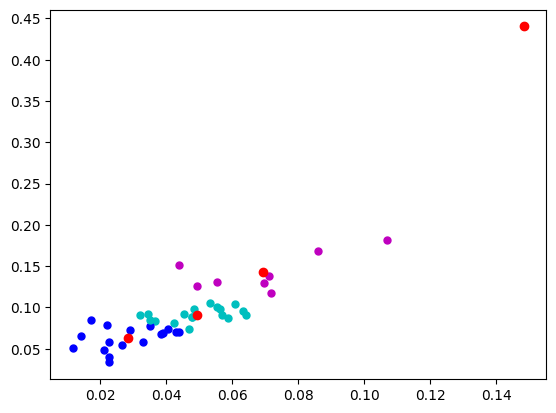

In [7]:
w_h = []
# Get list width & height of all images
df = pd.read_csv('./dataset/data_csv.csv', index_col=False)
for i in range(len(df)):
  w_h.append(list(df.iloc[i][-2:]))

kmeans = KMeans(n_clusters=4, random_state=0).fit(w_h)
cluster = kmeans.labels_

# Center points of each cluster
scales = kmeans.cluster_centers_

for i in range(len(cluster)):
    if cluster[i] == 0 :
        plt.plot(w_h[i][0],w_h[i][1], 'bo', markersize=5)
    if cluster[i] == 1 :
        plt.plot(w_h[i][0],w_h[i][1], 'go', markersize=5)
    if cluster[i] == 2 :
        plt.plot(w_h[i][0],w_h[i][1], 'co', markersize=5)
    if cluster[i] == 3 :
        plt.plot(w_h[i][0],w_h[i][1], 'mo', markersize=5)

plt.plot(scales[:,0],scales[:,1],'ro',markersize=6)
plt.show()

## Kmeans clustering separated by images' features extracted from vgg19 model
Step 1: Extract features of images by using VGG19

Step 2: Using kmeans to group those features

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True).to(device)
summary(vgg19, (3, 224, 224))  # Input size (Channel, Height, Width)

/home/hoang/anaconda3/envs/uavwater/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hoang/anaconda3/envs/uavwater/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Load all images to the variable X_Y 

In [11]:
def load_image(image_path, device):
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transformation(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor

# DIRECT THIS PATH TO "train" FOLDER CONTAINED .JPG IMAGES
images_path = sorted(glob.glob("dataset/images/*.jpg"))
features = list()

for i in range(len(images_path)):
    img = load_image(images_path[i], device)
    feature_map = vgg19.features(img)
    feature_map = feature_map.view(1, -1)
    features.append(feature_map.cpu().detach().numpy())
    
features = np.array(features).squeeze()
features.shape

(24, 57344)

/home/hoang/anaconda3/envs/uavwater/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


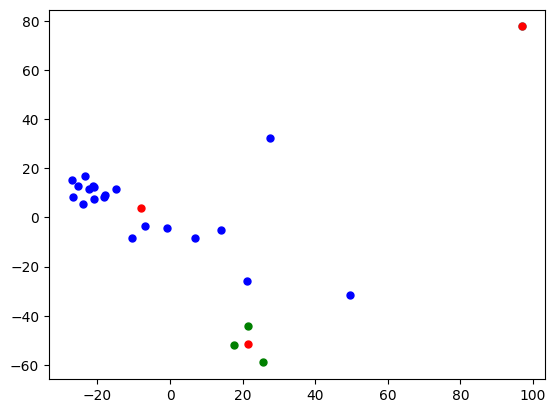

In [12]:
# PCA to reduce dimention
pca = PCA(n_components=24)
x = pca.fit_transform(features)

# Kmeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(x)
cluster = kmeans.labels_
scales = kmeans.cluster_centers_

for i in range(len(cluster)):
    if cluster[i] == 0 :
        plt.plot(x[i][0], x[i][1], 'bo', markersize=5)
    if cluster[i] == 1 :
        plt.plot(x[i][0], x[i][1], 'go', markersize=5)
    if cluster[i] == 2 :
        plt.plot(x[i][0], x[i][1], 'co', markersize=5)

plt.plot(scales[:,0], scales[:,1],'ro',markersize=5)
plt.plot()
plt.show()

## Visualize each group of images

In [28]:
# Plot images of each cluster (group)
def plotGroupImg(images_path, cluster, groupIdx):
  fig, ax = plt.subplots(2,3, figsize=(10, 6))
  ax = ax.flatten() # 25 images are selected randomly to plot out.
  indices = np.where(cluster == groupIdx)[0]
  items = np.random.choice(indices, size=len(ax), replace=False) if len(indices) > 6 else indices

  # for i in random.choices(range(len(idx_gr_0)), k=25):
  for i, item in enumerate(items):
    img  = cv2.imread(images_path[item])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    title = images_path[item].split("/")[-1]
    ax[i].set_title(title)
    ax[i].imshow(img)
  plt.show()

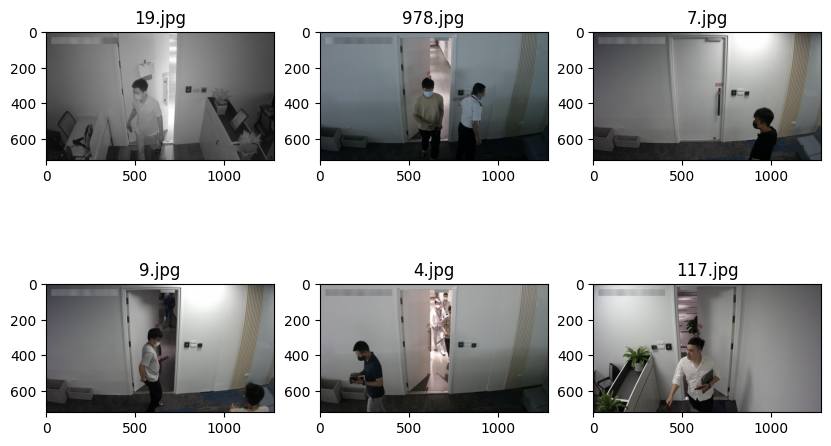

In [29]:
# Group 0
plotGroupImg(images_path, cluster, groupIdx=0)

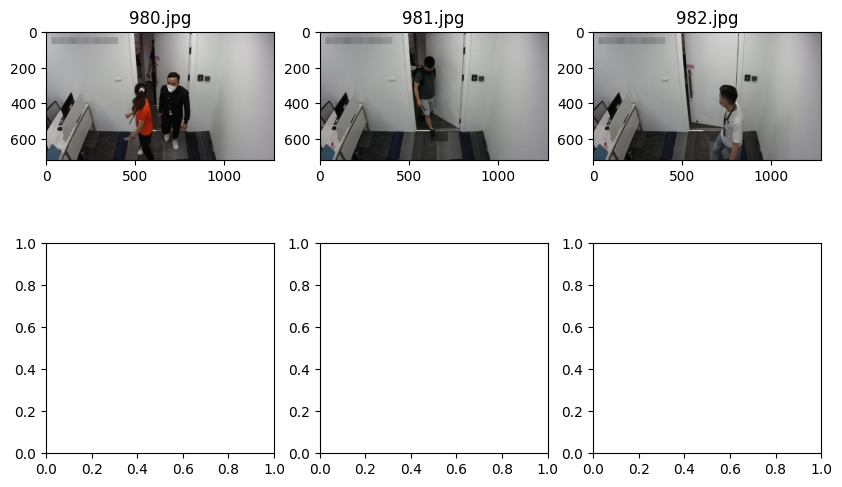

In [30]:
# Group 1
plotGroupImg(images_path, cluster, groupIdx=1)

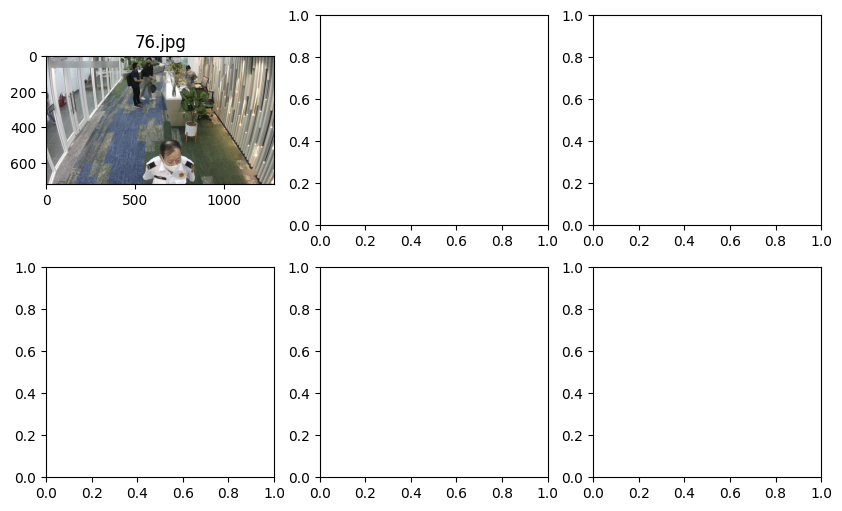

In [31]:
# Group 2
plotGroupImg(images_path, cluster, groupIdx=2)